In [48]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from catboost import CatBoostRegressor
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
import numpy as np

In [2]:
trainPath = r'dataset\train.csv'
testPath = r'dataset\test.csv'

In [3]:
trainData = pd.read_csv(trainPath)
trainData

,ID,electricity_kwh_per_month,natural_gas_therms_per_month,vehicle_miles_per_month,house_area_sqft,water_usage_liters_per_day,public_transport_usage_per_week,household_size,home_insulation_quality,meat_consumption_kg_per_week,laundry_loads_per_week,recycles_regularly,composts_organic_waste,uses_solar_panels,energy_efficient_appliances,heating_type,diet_type,owns_pet,smart_thermostat_installed,carbon_footprint
0,0xd6c,759.70,55.95,944.55,2422.07,541.27,1,3,2,4.23,9,1.0,0.0,0,1.0,gas,vegetarian,1,NaN,830.10
1,0x3fdf,387.06,70.59,1280.85,1995.3,280.39,1,2,1,3.27,8,0.0,0.0,0,0.0,electric,vegetarian,0,0.0,963.08
2,0x3b08,594.25,29.14,1005.72,2673.55,416.14,0,2,3,2.87,3,0.0,1.0,0,1.0,electric,omnivore,1,1.0,840.11
3,0x31e5,503.76,74.68,1049.46,2994.28,530.13,0,5,1,3.22,9,1.0,0.0,0,0.0,electric,omnivore,1,0.0,1252.42
4,0x397e,549.54,-77.00,756.49,2549.57,604.10,5,4,4,2.92,2,1.0,0.0,0,1.0,electric,vegetarian,0,1.0,580.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0x4aaa,324.96,43.37,438.36,1514.05,419.48,3,1,2,3.17,7,0.0,0.0,0,0.0,electric,omnivore,1,1.0,865.07
13996,0x36c3,581.19,83.50,1865.29,3357.9,651.11,0,1,3,6.60,3,1.0,1.0,0,0.0,gas,omnivore,1,0.0,1594.70
13997,0x3846,302.76,43.36,212.42,939.08,343.67,9,1,2,3.07,3,1.0,0.0,1,0.0,gas,omnivore,1,1.0,712.94
13998,0x4ba4,397.77,14.80,592.66,1164.04,271.67,2,7,0,2.48,4,1.0,0.0,1,0.0,gas,vegetarian,0,0.0,533.65


## **EDA**

In [4]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               14000 non-null  object 
 1   electricity_kwh_per_month        14000 non-null  float64
 2   natural_gas_therms_per_month     14000 non-null  float64
 3   vehicle_miles_per_month          14000 non-null  float64
 4   house_area_sqft                  14000 non-null  object 
 5   water_usage_liters_per_day       14000 non-null  float64
 6   public_transport_usage_per_week  14000 non-null  int64  
 7   household_size                   14000 non-null  object 
 8   home_insulation_quality          14000 non-null  int64  
 9   meat_consumption_kg_per_week     14000 non-null  float64
 10  laundry_loads_per_week           14000 non-null  int64  
 11  recycles_regularly               13590 non-null  float64
 12  composts_organic_w

In [5]:
trainData.energy_efficient_appliances.unique()

array([ 1.,  0., nan])

In [6]:
trainData.owns_pet.unique()

array([1, 0])

In [9]:
trainData.carbon_footprint.min()

np.float64(310.0)

In [25]:
def outliers(df : pd.DataFrame, column_name : str):
    df_in = df.copy()

    Q1 = df_in[column_name].quantile(0.25)
    Q3 = df_in[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_in[(df_in[column_name] < lower_bound) |
                    (df_in[column_name] > upper_bound)]
    
    plt.figure(figsize=(20, 5))
    plt.boxplot(trainData[column_name] , vert=False)
    plt.show()

    print("Outliers:")
    print(outliers[[column_name]])

    return upper_bound, lower_bound


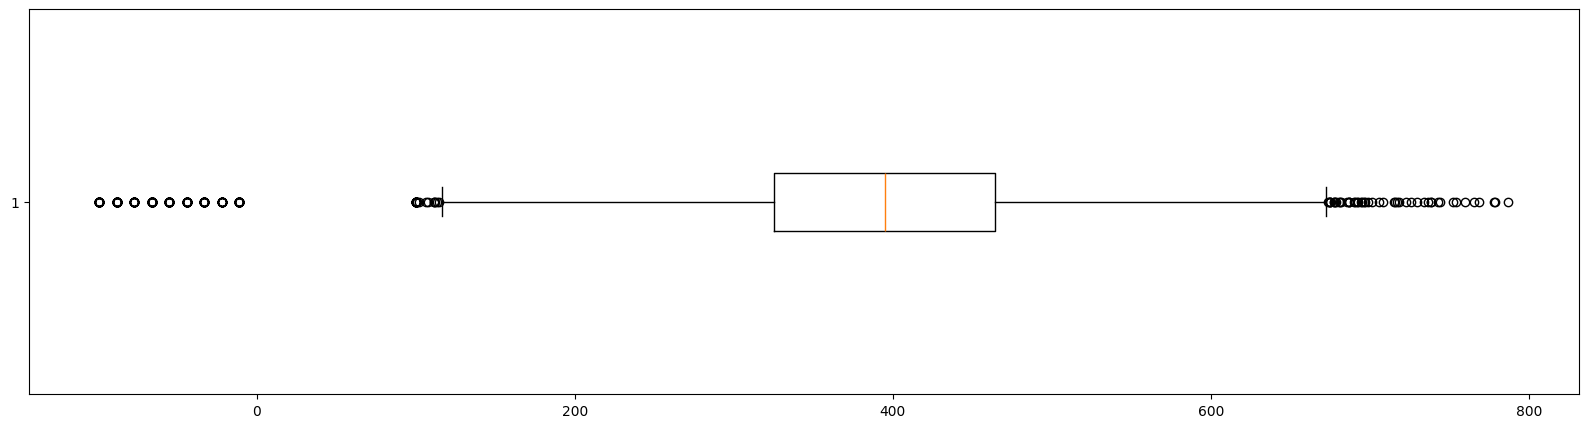

Outliers:
       electricity_kwh_per_month
0                         759.70
40                        -55.00
69                        -88.00
94                        -33.00
126                       -77.00
...                          ...
13853                     -77.00
13876                     -99.00
13977                     -11.00
13983                     696.77
13987                     -77.00

[369 rows x 1 columns]


In [26]:
upper_bound_elec, lower_bound_elec = outliers(trainData, 'electricity_kwh_per_month')

A important question arises here that is should we remove these outliers, since electricity usage can vary from house to house and high usage may not neccesarily be outliers but just characterstic of the data.

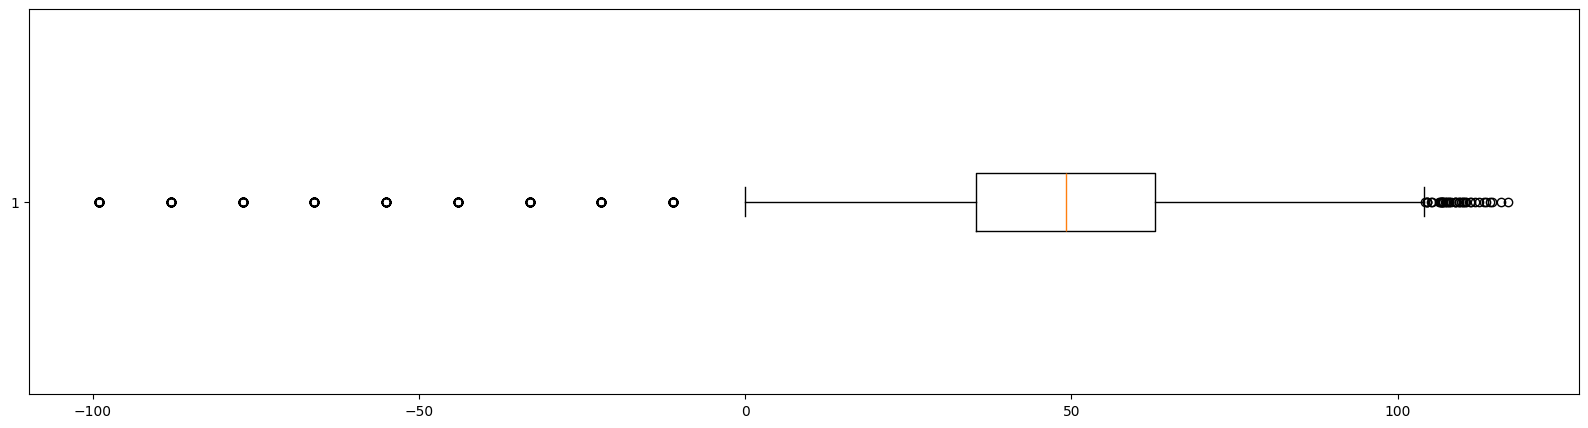

Outliers:
       natural_gas_therms_per_month
4                            -77.00
72                           -11.00
104                          -33.00
131                          -66.00
152                          -33.00
...                             ...
13893                        104.45
13907                        107.29
13922                        -77.00
13952                        -44.00
13954                        -99.00

[331 rows x 1 columns]


In [28]:
upper_bound_gas, lower_bound_gas = outliers(trainData, 'natural_gas_therms_per_month')

In [30]:
trainData.natural_gas_therms_per_month = trainData.natural_gas_therms_per_month.clip(lower=0)

A point could be made here also, but gas usage can't be a negative value.

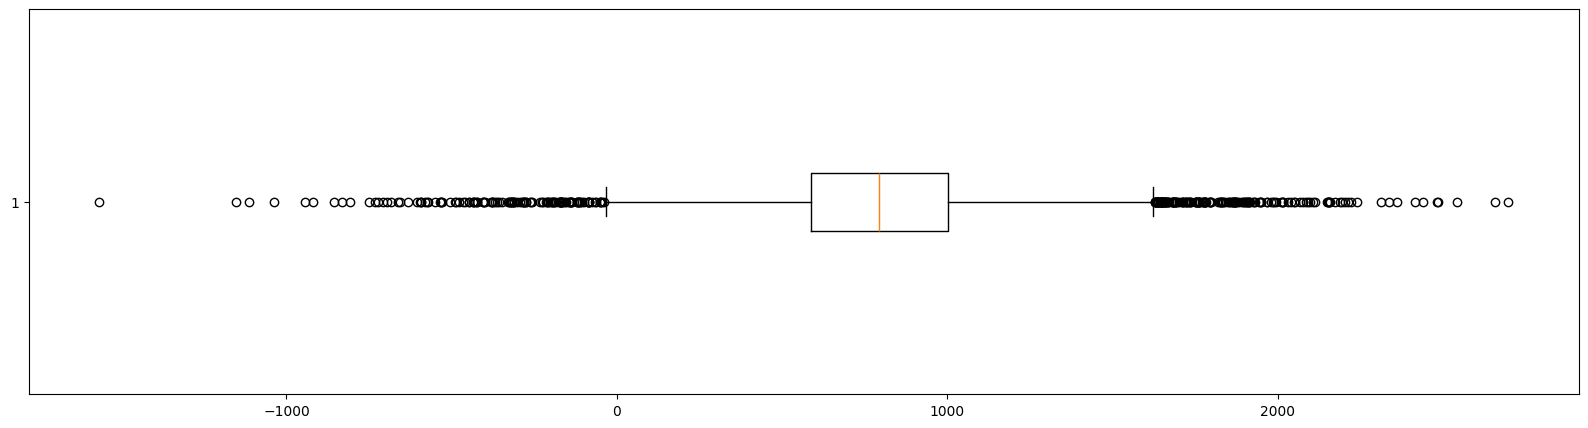

Outliers:
       vehicle_miles_per_month
17                 1645.640000
55                 -209.101901
66                 1794.484160
118                2155.209928
154                1876.046083
...                        ...
13812              1883.763297
13900              -213.728563
13911              1872.494028
13959              -662.695119
13996              1865.290000

[312 rows x 1 columns]


In [31]:
upper_bound_gas, lower_bound_gas = outliers(trainData, 'vehicle_miles_per_month')

In [33]:
trainData.vehicle_miles_per_month = trainData.vehicle_miles_per_month.clip(lower=0)

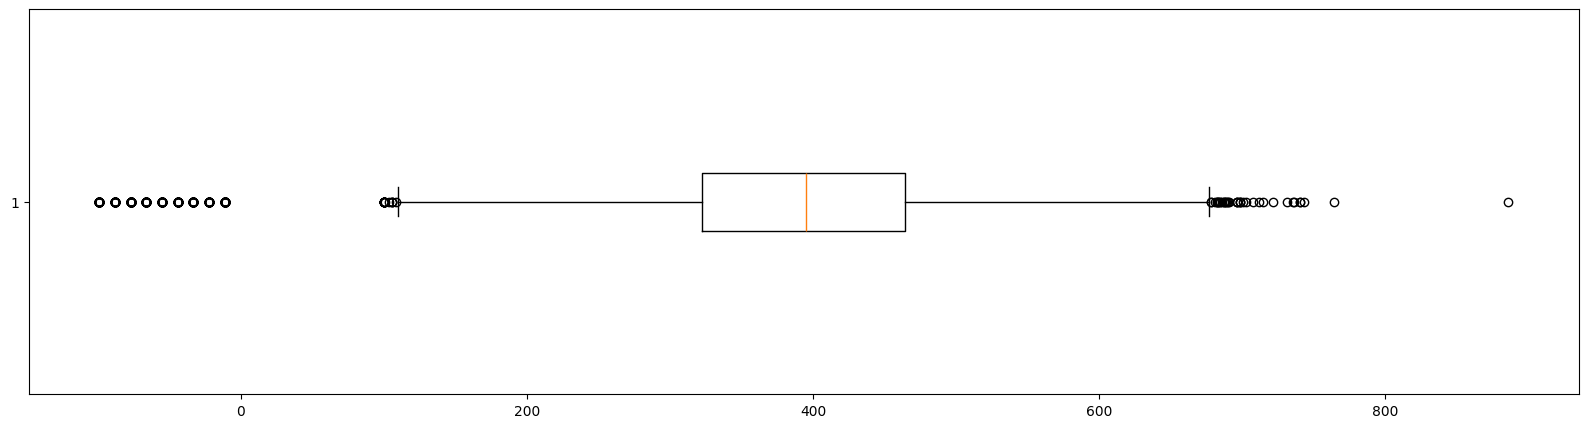

Outliers:
       water_usage_liters_per_day
12                         -55.00
50                         -66.00
51                         -88.00
74                         -11.00
84                         -55.00
...                           ...
13901                      -44.00
13915                      -88.00
13959                      -33.00
13975                      690.41
13991                      103.49

[488 rows x 1 columns]


In [35]:
upper_bound_water, lower_bound_water = outliers(trainData, 'water_usage_liters_per_day')

In [36]:
trainData.water_usage_liters_per_day = trainData.water_usage_liters_per_day.abs()

Can't be living without water

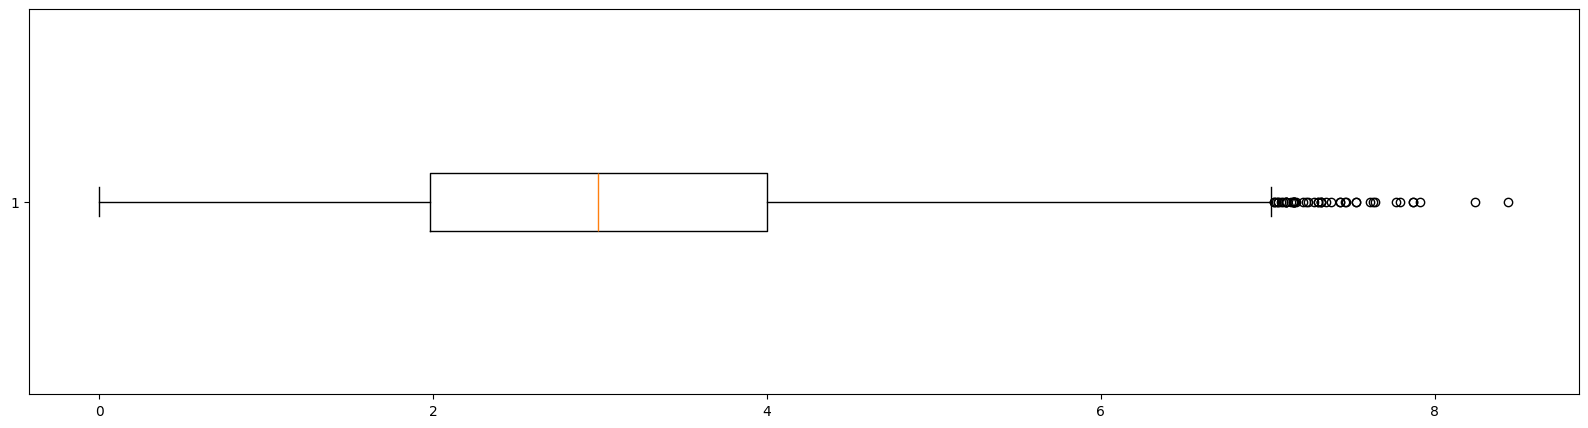

Outliers:
       meat_consumption_kg_per_week
276                            7.04
364                            7.87
784                            7.46
806                            7.06
1302                           7.43
1390                           7.15
2128                           7.05
2365                           7.14
2517                           7.30
2581                           7.11
2596                           7.43
2759                           8.24
3151                           7.32
3300                           7.32
4060                           7.16
4092                           7.17
4438                           7.53
4673                           7.79
4722                           7.38
4754                           7.47
4771                           7.53
5272                           7.91
5661                           7.11
5929                           7.87
6103                           7.28
6125                           7.23
6147              

In [38]:
upper_bound_meat, lower_bound_meat = outliers(trainData, 'meat_consumption_kg_per_week')

Could be due to more Members in the household

In [43]:
def draw_pie(series: pd.Series, figsize: tuple = (7.5, 7.5), title : str = None, ax=None):
    values = series.value_counts()
    labels = values.index
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.set_title(title)

def plot_bar(x, height, title : str = None, y_label : str = None, x_label : str = None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))

    bars = ax.bar(x, height, color='royalblue', edgecolor='black')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:,.0f}", 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

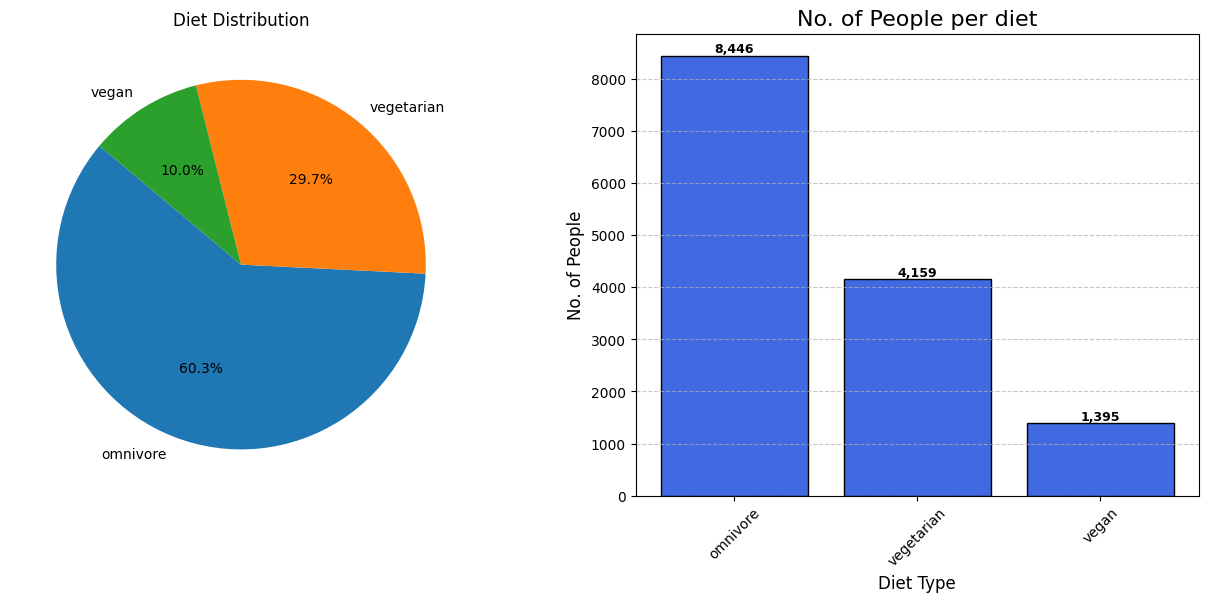

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

draw_pie(trainData.diet_type, title= 'Diet Distribution', ax=axes[0])
plot_bar(trainData.diet_type.value_counts().index, trainData.diet_type.value_counts().values, ax = axes[1], title='No. of People per diet', x_label= 'Diet Type', y_label='No. of People')

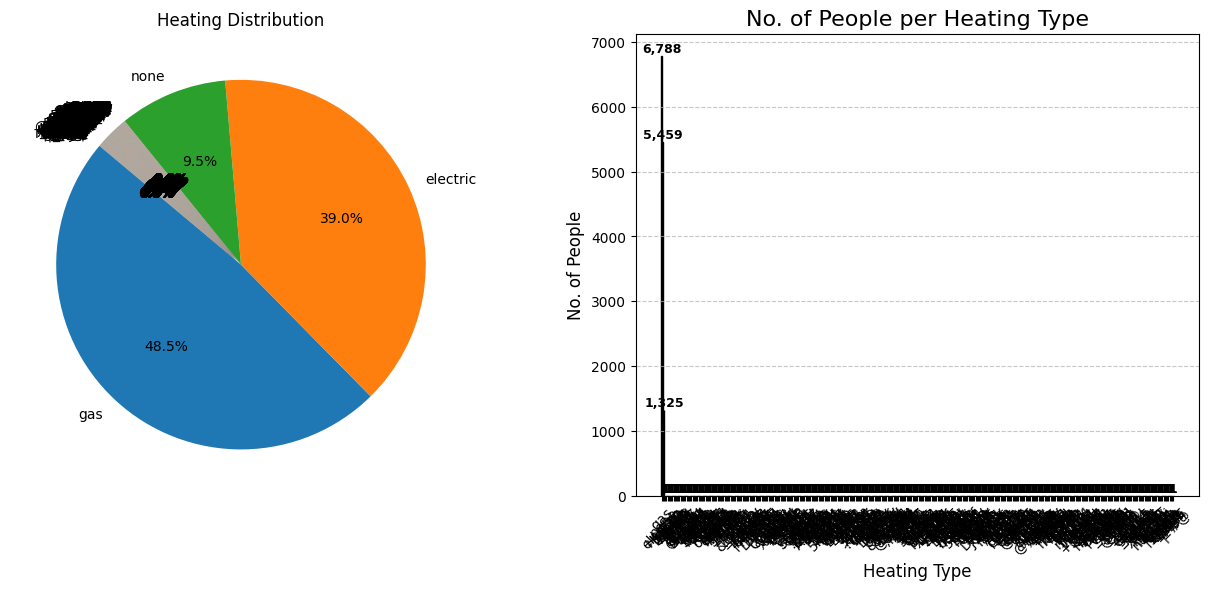

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

draw_pie(trainData.heating_type, title= 'Heating Distribution', ax=axes[0])
plot_bar(trainData.heating_type.value_counts().index, trainData.heating_type.value_counts().values, ax = axes[1], title='No. of People per Heating Type', x_label= 'Heating Type', y_label='No. of People')

Heating Type has a lot of Noise so better to drop it.

## **Data Preprocessing & Feature Engineering**

In [4]:
def convert_to_object(df):
    """Convert environmental behavior flags to 'yes'/'no' categorical strings."""
    df_in = df.copy()
    columns = [
        'recycles_regularly',
        'composts_organic_waste',
        'smart_thermostat_installed',
        'uses_solar_panels',
        'energy_efficient_appliances',
        'owns_pet'
    ]
    for col in columns:
        df_in[col] = df_in[col].apply(lambda x: 'yes' if x == 1.0 else ('no' if x == 0.0 else np.nan)).astype('object')
    return df_in

def convert_to_float(df):
    """Convert household_size and house_area_sqft to floats safely."""
    df_in = df.copy()
    df_in['house_area_sqft'] = pd.to_numeric(df_in['house_area_sqft'], errors='coerce')
    df_in['household_size'] = pd.to_numeric(df_in['household_size'], errors='coerce')
    return df_in

def drop_heating_type(df):
    """Drop the heating_type column."""
    df_in = df.copy()
    if 'heating_type' in df_in.columns:
        df_in = df_in.drop(columns=['heating_type'])
    return df_in

In [5]:
def calculate_total_resource_consumption(df):
    """Calculate total resource consumption per day and add a new column."""
    df_in = df.copy()
    df_in['electricity_per_day'] = df_in['electricity_kwh_per_month'] / 30
    df_in['natural_gas_per_day'] = df_in['natural_gas_therms_per_month'] / 30
    df_in['vehicle_miles_per_day'] = df_in['vehicle_miles_per_month'] / 30
    df_in['total_resource_per_day'] = (df_in['electricity_per_day'] + 
                                    df_in['natural_gas_per_day'] + 
                                    df_in['vehicle_miles_per_day'] + 
                                    df_in['water_usage_liters_per_day'])
    return df_in

def calculate_energy_efficiency(df):
    """Calculate a basic energy efficiency score and add a new column."""
    df_in = df.copy()
    df_in['energy_efficiency_score'] = (
        (df_in['home_insulation_quality'].fillna(0) / 5) +  
        df_in['energy_efficient_appliances'].fillna(0) + 
        df_in['smart_thermostat_installed'].fillna(0) + 
        df_in['uses_solar_panels'].fillna(0)
    ) / 4  
    return df_in

def calculate_resource_usage_per_person(df):
    """Calculate resource usage per person (electricity, water, vehicle, etc.)."""
    df_in = df.copy()
    df_in['electricity_per_person'] = df_in['electricity_kwh_per_month'] / df_in['household_size']
    df_in['water_per_person'] = df_in['water_usage_liters_per_day'] / df_in['household_size']
    df_in['vehicle_miles_per_person'] = df_in['vehicle_miles_per_month'] / df_in['household_size']
    return df_in

def calculate_sustainability_index(df):
    """Calculate sustainability index based on eco-friendly behaviors."""
    df_in = df.copy()
    df_in['sustainability_index'] = (
        df_in['recycles_regularly'].fillna(0) + 
        df_in['composts_organic_waste'].fillna(0) + 
        df_in['uses_solar_panels'].fillna(0) + 
        df_in['energy_efficient_appliances'].fillna(0) +
        df_in['diet_type'].apply(lambda x: 1 if x in ['vegan', 'vegetarian'] else 0)
    )
    return df_in

In [6]:
X = trainData.copy().drop(columns=['carbon_footprint', 'ID'])
Y = trainData.carbon_footprint

In [7]:
imputer_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [8]:
feature_pipeline = Pipeline([
    ('drop_heating_type', FunctionTransformer(drop_heating_type)),
    ('convert_float', FunctionTransformer(convert_to_float)),
    ('add_energy_efficiency', FunctionTransformer(calculate_energy_efficiency)),
    ('add_resource_usage_per_person', FunctionTransformer(calculate_resource_usage_per_person)),
    ('add_sustainability_index', FunctionTransformer(calculate_sustainability_index)),
    ('add_total_resource_consumption', FunctionTransformer(calculate_total_resource_consumption)),
    ('convert_object', FunctionTransformer(convert_to_object))
]).set_output(transform='pandas')

In [9]:
Xfeatured = feature_pipeline.fit_transform(X)

In [10]:
Xfeatured

,electricity_kwh_per_month,natural_gas_therms_per_month,vehicle_miles_per_month,house_area_sqft,water_usage_liters_per_day,public_transport_usage_per_week,household_size,home_insulation_quality,meat_consumption_kg_per_week,laundry_loads_per_week,...,smart_thermostat_installed,energy_efficiency_score,electricity_per_person,water_per_person,vehicle_miles_per_person,sustainability_index,electricity_per_day,natural_gas_per_day,vehicle_miles_per_day,total_resource_per_day
0,759.70,55.95,944.55,2422.07,541.27,1,3.0,2,4.23,9,...,NaN,0.35,253.233333,180.423333,314.850000,3.0,25.323333,1.865000,31.485000,599.943333
1,387.06,70.59,1280.85,1995.30,280.39,1,2.0,1,3.27,8,...,no,0.05,193.530000,140.195000,640.425000,1.0,12.902000,2.353000,42.695000,338.340000
2,594.25,29.14,1005.72,2673.55,416.14,0,2.0,3,2.87,3,...,yes,0.65,297.125000,208.070000,502.860000,2.0,19.808333,0.971333,33.524000,470.443667
3,503.76,74.68,1049.46,2994.28,530.13,0,5.0,1,3.22,9,...,no,0.05,100.752000,106.026000,209.892000,1.0,16.792000,2.489333,34.982000,584.393333
4,549.54,-77.00,756.49,2549.57,604.10,5,4.0,4,2.92,2,...,yes,0.70,137.385000,151.025000,189.122500,3.0,18.318000,-2.566667,25.216333,645.067667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,324.96,43.37,438.36,1514.05,419.48,3,1.0,2,3.17,7,...,yes,0.35,324.960000,419.480000,438.360000,0.0,10.832000,1.445667,14.612000,446.369667
13996,581.19,83.50,1865.29,3357.90,651.11,0,1.0,3,6.60,3,...,no,0.15,581.190000,651.110000,1865.290000,2.0,19.373000,2.783333,62.176333,735.442667
13997,302.76,43.36,212.42,939.08,343.67,9,1.0,2,3.07,3,...,yes,0.60,302.760000,343.670000,212.420000,2.0,10.092000,1.445333,7.080667,362.288000
13998,397.77,14.80,592.66,1164.04,271.67,2,7.0,0,2.48,4,...,no,0.25,56.824286,38.810000,84.665714,3.0,13.259000,0.493333,19.755333,305.177667


In [11]:
categorical_columns = Xfeatured.select_dtypes(include=['object','category']).columns
numerical_columns = Xfeatured.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
    ('num', numerical_transformer, numerical_columns),
    ('categorical', categorical_transformer, categorical_columns)
], remainder='passthrough', sparse_threshold=0)

In [12]:
preprocessor_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [13]:
Xtransform = preprocessor_pipeline.fit_transform(Xfeatured)

In [14]:
Xtransform.shape

(14000, 34)

In [15]:
YNormalized = np.log(Y.values) - 6.5

In [16]:
x_train, x_val, y_train, y_val = train_test_split(Xtransform, YNormalized, test_size=0.2, random_state=42)

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(11200, 34)
(11200,)
(2800, 34)
(2800,)


## **Linear Regression**

In [94]:
linear = LinearRegression()

linear.fit(x_train, y_train)

LinearRegression()

In [95]:
val_predictions_lr = linear.predict(x_val)

print(mse(y_val, val_predictions_lr))
print(r2(y_val, val_predictions_lr))

0.007411541774408575
0.8840639742746474


In [18]:
testData = pd.read_csv(testPath)

In [19]:
testfeatured = feature_pipeline.transform(testData)
x_test = preprocessor_pipeline.transform(testfeatured)

In [99]:
predictions_linear = linear.predict(x_test)
predictions_linear = np.exp(predictions_linear + 6.5)
submission_linear = testData[['ID']].copy()

submission_linear['carbon_footprint'] = predictions_linear
submission_linear.to_csv(r'submissions\SubmissionLR.csv', index=False)

## **XGBoost**

In [101]:
xgb = XGBRegressor(tree_method='hist', objective='reg:squarederror', random_state=42, device='cuda')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'colsample_bytree': [0.8, 1],
    'reg_lambda': [1, 10],
    'reg_alpha': [0, 1]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5)

grid_search.fit(x_train, y_train)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:729: UserWarning: [21:09:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=No...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1], 'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200], 'reg_alpha': [0, 1],
                         'reg_lambda': [1, 10]},
             scoring='neg_mean_squared_error')

In [102]:
print(grid_search.best_params_)

tuned_xgb = grid_search.best_estimator_

val_predictions_xgb = tuned_xgb.predict(x_val)

print(mse(y_val, val_predictions_xgb))
print(r2(y_val, val_predictions_xgb))

{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 10}
0.006365938579814671
0.9004199609986949


In [103]:
predictions_xgb = tuned_xgb.predict(x_test)
predictions_xgb = np.exp(predictions_xgb + 6.5)
submission_xgb = testData[['ID']].copy()

submission_xgb['carbon_footprint'] = predictions_xgb
submission_xgb.to_csv(r'submissions\SubmissionXGB.csv', index=False)

## **NN**

In [104]:
print(x_train.dtype, y_train.dtype)

x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

x_val = np.array(x_val).astype(np.float32)
y_val = np.array(y_val).astype(np.float32)


train_tensor = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(256).prefetch(tf.data.AUTOTUNE)
val_tensor = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(256).prefetch(tf.data.AUTOTUNE)

float64 float64


In [117]:
def create_model(trial):
    model = tf.keras.Sequential()
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        num_hidden = trial.suggest_int(f'n_units_l{i}', 32, 512, step=32)
        model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
        
        dropout_rate = trial.suggest_float(f'dropout_l{i}', 0.0, 0.5)
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(1))  

    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss='mse', optimizer=optimizer)
    return model


def objective(trial):
    model = create_model(trial)
    
    history = model.fit(
        train_tensor,
        validation_data=val_tensor,
        epochs=50,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    )

    y_pred = model.predict(x_val).flatten()
    return mse(y_val, y_pred)


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print("  Value (MSE):", trial.value)
print("  Params:", trial.params)

[I 2025-04-28 21:57:26,775] A new study created in memory with name: no-name-fc1a71c9-4b44-4c46-8a1b-99333c70314f


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-28 21:57:33,656] Trial 0 finished with value: 0.008831107057631016 and parameters: {'n_layers': 3, 'n_units_l0': 352, 'dropout_l0': 0.06306281726024815, 'n_units_l1': 160, 'dropout_l1': 0.23928377852321658, 'n_units_l2': 320, 'dropout_l2': 0.4894747766988484, 'lr': 7.695003912234595e-05}. Best is trial 0 with value: 0.008831107057631016.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-28 21:57:40,652] Trial 1 finished with value: 0.00789927039295435 and parameters: {'n_layers': 3, 'n_units_l0': 288, 'dropout_l0': 0.3816726679880545, 'n_units_l1': 128, 'dropout_l1': 0.020394058250039204, 'n_units_l2': 64, 'dropout_l2': 0.02399269840636914, 'lr': 0.0001627729499157895}. Best is trial 1 with value: 0.00789927039295435.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step


[I 2025-04-28 21:57:43,270] Trial 2 finished with value: 0.007063047494739294 and parameters: {'n_layers': 2, 'n_units_l0': 320, 'dropout_l0': 0.30212163938965847, 'n_units_l1': 96, 'dropout_l1': 0.4591243398935739, 'lr': 0.00854630596355269}. Best is trial 2 with value: 0.007063047494739294.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-04-28 21:57:47,763] Trial 3 finished with value: 0.00708770053461194 and parameters: {'n_layers': 3, 'n_units_l0': 416, 'dropout_l0': 0.14090216070371953, 'n_units_l1': 160, 'dropout_l1': 0.05784110486087124, 'n_units_l2': 224, 'dropout_l2': 0.247530144847197, 'lr': 0.0027195219251077646}. Best is trial 2 with value: 0.007063047494739294.


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-04-28 21:57:58,121] Trial 4 finished with value: 0.006807905156165361 and parameters: {'n_layers': 3, 'n_units_l0': 448, 'dropout_l0': 0.0937330219363684, 'n_units_l1': 128, 'dropout_l1': 0.0027299930843543985, 'n_units_l2': 256, 'dropout_l2': 0.24639209496890163, 'lr': 8.916276098963876e-05}. Best is trial 4 with value: 0.006807905156165361.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


[I 2025-04-28 21:58:05,950] Trial 5 finished with value: 0.008328959345817566 and parameters: {'n_layers': 2, 'n_units_l0': 416, 'dropout_l0': 0.18355738062817978, 'n_units_l1': 96, 'dropout_l1': 0.2301584451282136, 'lr': 5.210250916209211e-05}. Best is trial 4 with value: 0.006807905156165361.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-04-28 21:58:16,312] Trial 6 finished with value: 0.007797721307724714 and parameters: {'n_layers': 2, 'n_units_l0': 384, 'dropout_l0': 0.17256077115337515, 'n_units_l1': 512, 'dropout_l1': 0.20451558031092354, 'lr': 0.0001613620195724461}. Best is trial 4 with value: 0.006807905156165361.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


[I 2025-04-28 21:58:23,150] Trial 7 finished with value: 0.006451739463955164 and parameters: {'n_layers': 1, 'n_units_l0': 448, 'dropout_l0': 0.13336757776835412, 'lr': 0.0008205596949087281}. Best is trial 7 with value: 0.006451739463955164.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-04-28 21:58:26,954] Trial 8 finished with value: 0.010335651226341724 and parameters: {'n_layers': 3, 'n_units_l0': 384, 'dropout_l0': 0.26955409747113696, 'n_units_l1': 384, 'dropout_l1': 0.4603854992446005, 'n_units_l2': 96, 'dropout_l2': 0.2766532544544447, 'lr': 0.002019310074367977}. Best is trial 7 with value: 0.006451739463955164.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-28 21:58:36,745] Trial 9 finished with value: 0.008625195361673832 and parameters: {'n_layers': 3, 'n_units_l0': 288, 'dropout_l0': 0.054098820459054786, 'n_units_l1': 96, 'dropout_l1': 0.17186402160106123, 'n_units_l2': 160, 'dropout_l2': 0.4923910235398654, 'lr': 3.672539182822835e-05}. Best is trial 7 with value: 0.006451739463955164.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-28 21:58:42,410] Trial 10 finished with value: 0.006936531979590654 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout_l0': 0.48437249830261975, 'lr': 0.0006359778352509118}. Best is trial 7 with value: 0.006451739463955164.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-28 21:58:50,904] Trial 11 finished with value: 0.00907947402447462 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout_l0': 0.00463817916413245, 'lr': 1.0956572699594126e-05}. Best is trial 7 with value: 0.006451739463955164.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-28 21:58:58,614] Trial 12 finished with value: 0.006500340066850185 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout_l0': 0.11553047509202352, 'lr': 0.0004638290686538492}. Best is trial 7 with value: 0.006451739463955164.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-04-28 21:59:08,375] Trial 13 finished with value: 0.0064310249872505665 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout_l0': 0.21121842061695714, 'lr': 0.0004876885414496247}. Best is trial 13 with value: 0.0064310249872505665.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-04-28 21:59:17,798] Trial 14 finished with value: 0.006351848132908344 and parameters: {'n_layers': 1, 'n_units_l0': 160, 'dropout_l0': 0.2068267109266478, 'lr': 0.001212345788546919}. Best is trial 14 with value: 0.006351848132908344.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


[I 2025-04-28 21:59:23,481] Trial 15 finished with value: 0.006365326698869467 and parameters: {'n_layers': 1, 'n_units_l0': 160, 'dropout_l0': 0.22135431931231433, 'lr': 0.002555386860724926}. Best is trial 14 with value: 0.006351848132908344.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


[I 2025-04-28 21:59:25,773] Trial 16 finished with value: 0.006490205880254507 and parameters: {'n_layers': 1, 'n_units_l0': 160, 'dropout_l0': 0.3287764226099169, 'lr': 0.00995012248911421}. Best is trial 14 with value: 0.006351848132908344.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


[I 2025-04-28 21:59:29,499] Trial 17 finished with value: 0.010209465399384499 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'dropout_l0': 0.23006109889050455, 'n_units_l1': 288, 'dropout_l1': 0.36608499906840264, 'lr': 0.0016557601532210474}. Best is trial 14 with value: 0.006351848132908344.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-04-28 21:59:34,156] Trial 18 finished with value: 0.0065945046953856945 and parameters: {'n_layers': 1, 'n_units_l0': 192, 'dropout_l0': 0.3661019106744299, 'lr': 0.003652915959007488}. Best is trial 14 with value: 0.006351848132908344.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-04-28 21:59:42,521] Trial 19 finished with value: 0.007636601570993662 and parameters: {'n_layers': 2, 'n_units_l0': 224, 'dropout_l0': 0.2610624661030293, 'n_units_l1': 512, 'dropout_l1': 0.33341408378405357, 'lr': 0.004647607672691676}. Best is trial 14 with value: 0.006351848132908344.


Best trial:
  Value (MSE): 0.006351848132908344
  Params: {'n_layers': 1, 'n_units_l0': 160, 'dropout_l0': 0.2068267109266478, 'lr': 0.001212345788546919}


In [118]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(160, activation='relu'),
    tf.keras.layers.Dropout(0.2068267109266478),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001212345788546919),
              metrics=['mse', 'r2_score'])

In [119]:
model.fit(train_tensor,
          validation_data=val_tensor,
          epochs=75)

Epoch 1/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1731 - mse: 0.1731 - r2_score: -1.7365 - val_loss: 0.0195 - val_mse: 0.0195 - val_r2_score: 0.6946
Epoch 2/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0528 - mse: 0.0528 - r2_score: 0.1620 - val_loss: 0.0126 - val_mse: 0.0126 - val_r2_score: 0.8026
Epoch 3/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352 - mse: 0.0352 - r2_score: 0.4417 - val_loss: 0.0109 - val_mse: 0.0109 - val_r2_score: 0.8301
Epoch 4/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0265 - mse: 0.0265 - r2_score: 0.5798 - val_loss: 0.0097 - val_mse: 0.0097 - val_r2_score: 0.8488
Epoch 5/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219 - mse: 0.0219 - r2_score: 0.6523 - val_loss: 0.0092 - val_mse: 0.0092 - val_r2_score: 0.8564
Epoch 6/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178 - mse: 0.0178 - r2_score: 0.7169 - val_loss: 0.0087 - val_mse: 0.0087 - val_r2_score: 0.8642
Epoch 7/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

In [120]:
predictions_NN = model.predict(x_test)
predictions_NN = np.exp(predictions_NN + 6.5)
submission_NN = testData[['ID']].copy()

submission_NN['carbon_footprint'] = predictions_NN
submission_NN.to_csv(r'submissions\SubmissionNN.csv', index=False)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step


## **LightGBM**

In [31]:
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'device': 'gpu', 
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 1023),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
    }
    
    model = LGBMRegressor(**param)
        
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = cross_val_score(
        model, 
        x_train, 
        y_train, 
        scoring='neg_root_mean_squared_error', 
        cv=kf, 
        n_jobs=-1
    )
    
    return scores.mean()  

study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=50, timeout=3600)  

print("Best params:", study.best_params)
print("Best neg-RMSE:", study.best_value)


[I 2025-04-28 23:26:53,601] A new study created in memory with name: no-name-ba7c286b-2882-4bfc-871f-35435a95177a
[I 2025-04-28 23:27:05,784] Trial 0 finished with value: -0.08790308035892214 and parameters: {'learning_rate': 0.036616736105543744, 'num_leaves': 622, 'max_depth': 14, 'min_child_samples': 80, 'subsample': 0.795549114417158, 'colsample_bytree': 0.6407766841879319, 'reg_alpha': 0.0005330811724749926, 'reg_lambda': 0.0058689155306199895, 'min_split_gain': 0.0310627051660631, 'n_estimators': 907}. Best is trial 0 with value: -0.08790308035892214.
[I 2025-04-28 23:27:10,287] Trial 1 finished with value: -0.0944983519297304 and parameters: {'learning_rate': 0.2731223437311675, 'num_leaves': 205, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.7969292349719245, 'colsample_bytree': 0.5040990712152036, 'reg_alpha': 0.1760397147472674, 'reg_lambda': 3.977538253377343, 'min_split_gain': 0.08203132433191912, 'n_estimators': 1172}. Best is trial 0 with value: -0.0879030803589

Best params: {'learning_rate': 0.02767699081464663, 'num_leaves': 321, 'max_depth': 5, 'min_child_samples': 34, 'subsample': 0.532809035931003, 'colsample_bytree': 0.5648932078407829, 'reg_alpha': 0.0006058367578122122, 'reg_lambda': 0.30779044602767924, 'min_split_gain': 0.03333917277137181, 'n_estimators': 492}
Best neg-RMSE: -0.08703295433507442


In [36]:
params = {'objective': 'regression', 'metric': 'rmse',
        'boosting_type': 'gbdt', 'device': 'gpu', 'learning_rate': 0.02767699081464663, 
        'num_leaves': 321, 'max_depth': 5, 'min_child_samples': 34, 'subsample': 0.532809035931003, 
        'colsample_bytree': 0.5648932078407829, 'reg_alpha': 0.0006058367578122122, 
        'reg_lambda': 0.30779044602767924, 'min_split_gain': 0.03333917277137181, 'n_estimators': 492, 'max_bin':255}

modelLGM = LGBMRegressor(
    n_estimators=512,
    learning_rate=0.025,
    num_leaves=512,            
    max_depth=-1,
    subsample=0.7,
    colsample_bytree=0.7,
    max_bin=255,               
    objective='regression',
    random_state=42,
    device='gpu',
    boosting_type='gbdt',    
    gpu_use_dp=False,            
    tree_method='gpu_hist'       
)

In [37]:
modelLGM.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)],
    eval_metric='rmse',
    callbacks=[early_stopping(100), log_evaluation(100)]
)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.0908984	valid_0's l2: 0.00826252
[200]	valid_0's rmse: 0.0831773	valid_0's l2: 0.00691846
[300]	valid_0's rmse: 0.0823769	valid_0's l2: 0.00678595
[400]	valid_0's rmse: 0.0826329	valid_0's l2: 0.00682819
Early stopping, best iteration is:
[310]	valid_0's rmse: 0.0823686	valid_0's l2: 0.00678458


LGBMRegressor(colsample_bytree=0.7, device='gpu', gpu_use_dp=False,
              learning_rate=0.025, max_bin=255, n_estimators=512,
              num_leaves=512, objective='regression', random_state=42,
              subsample=0.7, tree_method='gpu_hist')

In [38]:
predictions_LGBM = modelLGM.predict(x_test)
predictions_LGBM = np.exp(predictions_LGBM + 6.5)
submission_LGBM = testData[['ID']].copy()

submission_LGBM['carbon_footprint'] = predictions_LGBM
submission_LGBM.to_csv(r'submissions\SubmissioLGBM.csv', index=False)

## **Blending**

In [39]:
class BlendingRegressor:
    def __init__(self):
        self.xgb_params = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 10, 'tree_method':'hist', 'device':'cuda'}
        self.base_models = [
            XGBRegressor(
                **self.xgb_params
            ),
            LGBMRegressor(
                n_estimators=512, learning_rate=0.025, num_leaves=512,            
                max_depth=-1, subsample=0.7, colsample_bytree=0.7, max_bin=255,               
                objective='regression', random_state=42, device='gpu',
                boosting_type='gbdt', gpu_use_dp=False, tree_method='gpu_hist'        
            ),
            CatBoostRegressor(
                task_type='GPU', verbose=0, iterations=500, depth=6, learning_rate=0.05
            ),
            MLPRegressor(hidden_layer_sizes=(64,), max_iter=500)
        ]

        self.meta_model = GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.1)

    def fit(self, X, y):
        X_base, X_holdout, y_base, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

        self.fitted_base_models = []
        self.model_holdout_scores = []

        meta_features = []
        for model in self.base_models:
            clone_model = clone(model)
            clone_model.fit(X_base, y_base)
            preds = clone_model.predict(X_holdout)
            score = -np.mean((preds - y_holdout) ** 2)  

            meta_features.append(preds)
            self.fitted_base_models.append(clone_model)
            self.model_holdout_scores.append(score)

        errors = np.array([np.sqrt(np.mean((p - y_holdout) ** 2)) for p in meta_features]) 
        weights = np.exp(-errors) 
        weights = weights / np.sum(weights)

        print(f"Model blending weights based on holdout -MSE: {weights}")

        meta_X = np.column_stack(meta_features) * weights

        self.meta_model.fit(meta_X, y_holdout)
        print("Elite BlendingRegressor trained!")

    def predict(self, X):
        meta_features = []
        for model in self.fitted_base_models:
            preds = model.predict(X)
            meta_features.append(preds)

        meta_X = np.column_stack(meta_features)
        meta_X = meta_X * np.array(self.model_holdout_scores) / np.sum(self.model_holdout_scores)

        return self.meta_model.predict(meta_X)

In [40]:
blendRegressor = BlendingRegressor()
blendRegressor.fit(x_train, y_train)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:729: UserWarning: [00:23:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Model blending weights based on holdout -MSE: [0.25096748 0.24968425 0.25136763 0.24798064]
Elite BlendingRegressor trained!


In [41]:
val_predictions_blend = blendRegressor.predict(x_val)

print(mse(y_val, val_predictions_blend))
print(r2(y_val, val_predictions_blend))

0.007042574757344122
0.8898355898013783


In [42]:
predictions_Blend = blendRegressor.predict(x_test)
predictions_Blend = np.exp(predictions_Blend + 6.5)
submission_Blend = testData[['ID']].copy()

submission_Blend['carbon_footprint'] = predictions_Blend
submission_Blend.to_csv(r'submissions\SubmissioBlend.csv', index=False)

## **Stacking**

In [50]:
class LayeredStackingRegressor:
    def __init__(self):
        self.layer1_models = [
            XGBRegressor(tree_method='hist', device='cuda'),
            MLPRegressor(alpha = 0.0001, hidden_layer_sizes = (32,), learning_rate_init = 0.001, max_iter=500),
            XGBRegressor(tree_method='hist', device='cuda'),
            MLPRegressor(alpha = 0.0001, hidden_layer_sizes = (16,), learning_rate_init = 0.001, max_iter=500),
            XGBRegressor(tree_method='hist', device='cuda'),
            MLPRegressor(alpha = 0.0001, hidden_layer_sizes = (32,), learning_rate_init = 0.001, max_iter=500),
            XGBRegressor(tree_method='hist', device='cuda')
        ]

        self.layer2_models = [
            LGBMRegressor(max_bin=255, objective='regression', random_state=42, device='gpu', boosting_type='gbdt', gpu_use_dp=False, verbose=-1),
            LGBMRegressor(max_bin=255, objective='regression', random_state=42, device='gpu', boosting_type='gbdt', gpu_use_dp=False, verbose=-1),
            CatBoostRegressor(task_type="GPU", verbose=0),
            LGBMRegressor(max_bin=255, objective='regression', random_state=42, device='gpu', boosting_type='gbdt', gpu_use_dp=False, verbose=-1),
            LGBMRegressor(max_bin=255, objective='regression', random_state=42, device='gpu', boosting_type='gbdt', gpu_use_dp=False, verbose=-1)
        ]
        
        self.layer3_models = [
            LinearRegression(),
            Ridge(),
            LinearRegression()
        ]

        self.final_model = XGBRegressor( tree_method='hist', device='cuda')

    def fit(self, X, y):
        n_splits = 3
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Layer 1
        self.layer1_out = np.zeros((X.shape[0], len(self.layer1_models)))
        for idx, model in enumerate(self.layer1_models):
            clone_model = clone(model) 
            oof_preds = np.zeros(X.shape[0])
            for train_idx, val_idx in kf.split(X):
                clone_model.fit(X[train_idx], y[train_idx])
                oof_preds[val_idx] = clone_model.predict(X[val_idx])
            self.layer1_out[:, idx] = oof_preds

            model.fit(X, y)  
            print(f"Completed {idx + 1} pass of Layer 1")

        # Layer 2
        self.layer2_out = np.zeros((X.shape[0], len(self.layer2_models)))
        for idx, model in enumerate(self.layer2_models):
            clone_model = clone(model)
            oof_preds = np.zeros(X.shape[0])
            for train_idx, val_idx in kf.split(self.layer1_out):
                clone_model.fit(self.layer1_out[train_idx], y[train_idx])
                oof_preds[val_idx] = clone_model.predict(self.layer1_out[val_idx])
            self.layer2_out[:, idx] = oof_preds

            model.fit(self.layer1_out, y)
            print(f"Completed {idx + 1} pass of Layer 2")

        # Layer 3
        self.layer3_out = np.zeros((X.shape[0], len(self.layer3_models)))
        for idx, model in enumerate(self.layer3_models):
            clone_model = clone(model)
            oof_preds = np.zeros(X.shape[0])
            for train_idx, val_idx in kf.split(self.layer2_out):
                clone_model.fit(self.layer2_out[train_idx], y[train_idx])
                oof_preds[val_idx] = clone_model.predict(self.layer2_out[val_idx])
            self.layer3_out[:, idx] = oof_preds

            model.fit(self.layer2_out, y)
            print(f"Completed {idx + 1} pass of Layer 3")

        # Final model
        self.final_model.fit(self.layer3_out, y)
        print("Finished Stack Regressor with Final Model.")

        return self.final_model

    def predict(self, X):
        layer1_preds = np.column_stack([
            model.predict(X) for model in self.layer1_models
        ])
        layer2_preds = np.column_stack([
            model.predict(layer1_preds) for model in self.layer2_models
        ])
        layer3_preds = np.column_stack([
            model.predict(layer2_preds) for model in self.layer3_models
        ])
        return self.final_model.predict(layer3_preds)
    
    def layer_out(self):
        return self.layer1_out, self.layer2_out, self.layer3_out

In [51]:
stackingRegressor = LayeredStackingRegressor()
stackingRegressor.fit(x_train, y_train)

Completed 1 pass of Layer 1
Completed 2 pass of Layer 1
Completed 3 pass of Layer 1
Completed 4 pass of Layer 1
Completed 5 pass of Layer 1
Completed 6 pass of Layer 1
Completed 7 pass of Layer 1
Completed 1 pass of Layer 2
Completed 2 pass of Layer 2
Completed 3 pass of Layer 2
Completed 4 pass of Layer 2
Completed 5 pass of Layer 2
Completed 1 pass of Layer 3
Completed 2 pass of Layer 3
Completed 3 pass of Layer 3
Finished Stack Regressor with Final Model.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [52]:
val_predictions_stack = stackingRegressor.predict(x_val)

print(mse(y_val, val_predictions_stack))
print(r2(y_val, val_predictions_stack))

0.0069299037072516455
0.8915980616540133


In [53]:
predictions_stack = stackingRegressor.predict(x_test)
predictions_stack = np.exp(predictions_stack + 6.5)
submission_stack = testData[['ID']].copy()

submission_stack['carbon_footprint'] = predictions_stack
submission_stack.to_csv(r'submissions\Submissiostack.csv', index=False)